In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from IPython.display import display

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Load data
df = pd.read_csv("post_pandemic_remote_work_health_impact_2025.csv")
df.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


In [ ]:
# Filter to include only remote workers
df_remote = df[df["Work_Arrangement"] == "Remote"].copy()
df_remote.head()

,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
8,2025-06-01,30,Female,South America,Technology,Software Engineer,Remote,47,Anxiety,Medium,2,Neck Pain,4,$60K-80K
11,2025-06-01,64,Male,North America,Technology,Business Analyst,Remote,35,ADHD,Medium,3,Eye Strain; Wrist Pain,4,$40K-60K
13,2025-06-01,37,Male,Europe,Finance,UX Designer,Remote,59,Anxiety,High,5,Back Pain; Shoulder Pain; Wrist Pain,5,$60K-80K
14,2025-06-01,50,Male,Europe,Professional Services,Social Media Manager,Remote,64,Burnout,Medium,1,NaN,4,$60K-80K
19,2025-06-01,27,Female,Africa,Healthcare,Account Manager,Remote,43,NaN,Medium,1,NaN,4,$80K-100K


In [4]:
# Check for duplicates
print("Duplicates:", df_remote.duplicated().sum())

Duplicates: 0


In [5]:
# Quick look at nulls
print("Missing values per column:")
null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

Missing values per column:


,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,163
9,Burnout_Level,0


In [6]:
# Take care of columns with missing values
df_remote["Mental_Health_Status"] = df_remote["Mental_Health_Status"].fillna("None")
df_remote["Physical_Health_Issues"] = df_remote["Physical_Health_Issues"].fillna("None")

null_counts = df_remote.isnull().sum().reset_index()
null_counts.columns = ["Column", "Null Values"]
display(null_counts)

,Column,Null Values
0,Survey_Date,0
1,Age,0
2,Gender,0
3,Region,0
4,Industry,0
5,Job_Role,0
6,Work_Arrangement,0
7,Hours_Per_Week,0
8,Mental_Health_Status,0
9,Burnout_Level,0


In [7]:
# Get all issues in Physical_Health_Issues, split by ;
issues_p = set(
    df_remote["Physical_Health_Issues"]
    .str.split(";")
    .apply(lambda x: [issue.strip() for issue in x if issue.strip()])
    .explode()
    .dropna()
    .unique()
)
if "None" in issues_p:
    issues_p.remove("None")
issues_p.add("No Physical Health Issues")

issues_m = set(
    df_remote["Mental_Health_Status"]
    .str.split(";")
    .apply(lambda x: [issue.strip() for issue in x if issue.strip()])
    .explode()
    .dropna()
    .unique()
)
if "None" in issues_m:
    issues_m.remove("None")
issues_m.add("No Mental Health Issues")

display("Physical_Health_Issues:")
display(issues_p)
display("Mental_Health_Status:")
display(issues_m)

'Physical_Health_Issues:'

{'Back Pain',
 'Eye Strain',
 'Neck Pain',
 'No Physical Health Issues',
 'Shoulder Pain',
 'Wrist Pain'}

'Mental_Health_Status:'

{'ADHD',
 'Anxiety',
 'Burnout',
 'Depression',
 'No Mental Health Issues',
 'PTSD',
 'Stress Disorder'}

Note that Burnout is a mental health status and it's also our target variable. We should not include it in our features.

In [8]:
display(
    df_remote[df_remote["Mental_Health_Status"] == "Burnout"][
        "Burnout_Level"
    ].value_counts()
)

Burnout_Level
High      31
Medium    27
Low        5
Name: count, dtype: int64

There are 5 instances of low burnout with burnout as a mental health status. This may indicate that the survey participants are not fully aware of their burnout levels and they have misclassified themselves.

Let's remove instances where the burnout level is low and the mental health status is burnout. This will help us to focus on the more severe cases of burnout.

In [9]:
df_remote = df_remote[
    ~(
        (df_remote["Mental_Health_Status"] == "Burnout")
        & (df_remote["Burnout_Level"] == "Low")
    )
]
if "Burnout" in issues_m:
    issues_m.remove("Burnout")
display(
    df_remote[df_remote["Mental_Health_Status"] == "Burnout"][
        "Burnout_Level"
    ].value_counts()
)

Burnout_Level
High      31
Medium    27
Name: count, dtype: int64

In [10]:
# One-hot encode selected health issues for remote workers, using True/False
df_remote["Physical_Health_Issues"] = (
    df_remote["Physical_Health_Issues"]
    .replace("None", "No Physical Health Issues")
    .astype(str)
)
for issue in issues_p:
    colname = issue.replace(" ", "_")
    df_remote[colname] = df_remote["Physical_Health_Issues"].apply(lambda x: issue in x)

df_remote["Mental_Health_Status"] = (
    df_remote["Mental_Health_Status"]
    .replace("None", "No Mental Health Issues")
    .astype(str)
)
for issue in issues_m:
    colname = issue.replace(" ", "_")
    df_remote[colname] = df_remote["Mental_Health_Status"].apply(lambda x: issue in x)

In [11]:
# Categorical summaries (using display for better output)
categorical_cols = (
    {
        "Gender",
        "Region",
        "Industry",
        "Job_Role",
        "Work_Arrangement",
        "Burnout_Level",
        "Salary_Range",
    }
    .union([issue.replace(" ", "_") for issue in issues_p])
    .union([issue.replace(" ", "_") for issue in issues_m])
)
numericals_cols = (
    set(df_remote.columns)
    .difference(categorical_cols)
    .difference({"Mental_Health_Status", "Physical_Health_Issues", "Survey_Date"})
)

df_categorical = df_remote[list(categorical_cols)]
df_numerical = df_remote[list(numericals_cols)]

In [12]:
# Creating a dictionary to store the labeled dataframes
categorical_summary_dfs = {
    col: pd.concat(
        [
            df_categorical[col].value_counts(normalize=True),
            df_categorical[col].value_counts(),
        ],
        axis=1,
        keys=["proportion", "count"],
    )
    for col in df_categorical
}

# Concatenating along axis=0 with keys as column labels
categorical_summary_df = pd.concat(categorical_summary_dfs, axis=0)

# Displaying the dataframe
pd.set_option("display.max_rows", None)
display(categorical_summary_df)
pd.reset_option("display.max_rows")

proportion  count
Work_Arrangement          Remote                          1.000000    583
Region                    South America                   0.186964    109
                          Oceania                         0.173242    101
                          North America                   0.168096     98
                          Asia                            0.162950     95
                          Africa                          0.156089     91
                          Europe                          0.152659     89
Back_Pain                 True                            0.502573    293
                          False                           0.497427    290
Burnout_Level             High                            0.468268    273
                          Medium                          0.401372    234
                          Low                             0.130360     76
Anxiety                   False                           0.871355    508
                          True                            0.128645     75
PTSD                      False                           0.866209    505
                          True                            0.133791     78
No_Mental_Health_Issues   False                           0.720412    420
                          True                            0.279588    163
Depression                False                           0.885077    516
                          True                            0.114923     67
Neck_Pain                 False                           0.711835    415
                          True                            0.288165    168
Gender                    Male                            0.495712    289
                          Female                          0.468268    273
                          Non-binary                      0.024014     14
                          Prefer not to say               0.012007      7
Salary_Range              $60K-80K                        0.307033    179
                          $80K-100K                       0.289880    169
                          $40K-60K                        0.207547    121
                          $100K-120K                      0.128645     75
                          $120K+                          0.066895     39
No_Physical_Health_Issues False                           0.922813    538
                          True                            0.077187     45
ADHD                      False                           0.878216    512
                          True                            0.121784     71
Stress_Disorder           False                           0.878216    512
                          True                            0.121784     71
Shoulder_Pain             False                           0.535163    312
                          True                            0.464837    271
Industry                  Technology                      0.336192    196
                          Professional Services           0.162950     95
                          Manufacturing                   0.154374     90
                          Finance                         0.089194     52
                          Education                       0.078902     46
                          Healthcare                      0.053173     31
                          Customer Service                0.046312     27
                          Retail                          0.046312     27
                          Marketing                       0.032590     19
Wrist_Pain                False                           0.831904    485
                          True                            0.168096     98
Eye_Strain                True                            0.509434    297
                          False                           0.490566    286
Job_Role                  Operations Manager              0.053173     31
                          Research Scientist              0.

In [13]:
# Outlier checks
df_outliers = pd.DataFrame(
    {
        "Age < 18": df_numerical["Age"] < 18,
        "Age > 65": df_numerical["Age"] > 65,
        "Hours_Per_Week < 0": df_numerical["Hours_Per_Week"] < 0,
        "Hours_Per_Week > 80": df_numerical["Hours_Per_Week"] > 80,
    }
)
df_outliers = df_outliers.sum().reset_index()
df_outliers.columns = ["Condition", "Count"]
display(df_outliers)

,Condition,Count
0,Age < 18,0
1,Age > 65,0
2,Hours_Per_Week < 0,0
3,Hours_Per_Week > 80,0


## Exploratory Data Analysis (EDA) on Burnout in Remote Work

In [14]:
# Summary statistics for all numeric columns
display(df_numerical.describe())

# describe numerical columns based on Burnout level
for col in numericals_cols:
    print(f"Summary statistics for {col} by Burnout Level:")
    display(df_numerical.groupby(df_remote["Burnout_Level"])[col].describe())

,Hours_Per_Week,Age,Social_Isolation_Score,Work_Life_Balance_Score
count,583.000000,583.000000,583.000000,583.000000
mean,49.958834,44.233276,3.499142,2.993139
std,8.860606,12.491253,1.150041,1.205637
min,35.000000,22.000000,1.000000,1.000000
25%,43.000000,34.000000,3.000000,2.000000
50%,50.000000,45.000000,4.000000,3.000000
75%,57.500000,55.000000,4.000000,4.000000
max,65.000000,65.000000,5.000000,5.000000


Summary statistics for Hours_Per_Week by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,49.769231,9.085068,35.0,42.0,50.0,57.00,65.0
Low,76.0,49.552632,8.462300,35.0,43.0,49.0,56.25,65.0
Medium,234.0,50.311966,8.745379,35.0,43.0,50.0,58.00,65.0


Summary statistics for Age by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,44.498168,12.495330,22.0,34.00,45.0,56.00,65.0
Low,76.0,43.907895,12.621862,23.0,33.25,44.5,53.25,65.0
Medium,234.0,44.029915,12.491506,22.0,33.00,45.0,54.00,65.0


Summary statistics for Social_Isolation_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.446886,1.174922,1.0,3.0,4.0,4.0,5.0
Low,76.0,3.552632,1.136013,1.0,3.0,4.0,4.0,5.0
Medium,234.0,3.542735,1.127252,1.0,3.0,4.0,4.0,5.0


Summary statistics for Work_Life_Balance_Score by Burnout Level:


,count,mean,std,min,25%,50%,75%,max
Burnout_Level,,,,,,,,
High,273.0,3.036630,1.224195,1.0,2.0,3.0,4.0,5.0
Low,76.0,3.000000,1.200000,1.0,2.0,3.0,4.0,5.0
Medium,234.0,2.940171,1.188577,1.0,2.0,3.0,4.0,5.0


## Visualizations

In [15]:
def plot_boxplots(col):
    plt.figure(figsize=(12, 3))

    # plot distributions of each column for each burnout level for all numerical columns
    plt.subplot(1, 3, 1)
    # plot distributions of each column for each burnout level
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Low"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Low Burnout)")
    plt.subplot(1, 3, 2)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "Medium"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(Medium Burnout)")
    plt.subplot(1, 3, 3)
    sns.histplot(
        df_numerical[col].loc[df_remote["Burnout_Level"] == "High"],
        kde=True,
        discrete=True,
    )
    plt.title(f"{col} distribution\n(High Burnout)")
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    plt.show()

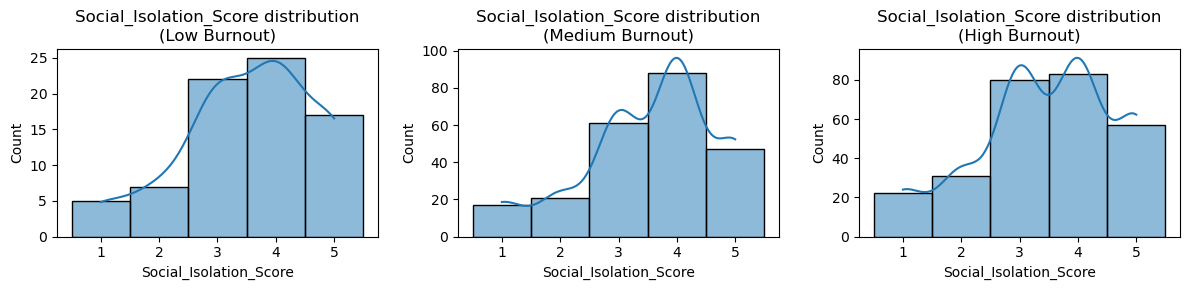

In [16]:
plot_boxplots('Social_Isolation_Score')

`Social_Isolation_Score` shows right-skewed distributions across all burnout levels. This indicates that most participants experience higher levels of social isolation, regardless of their burnout level.

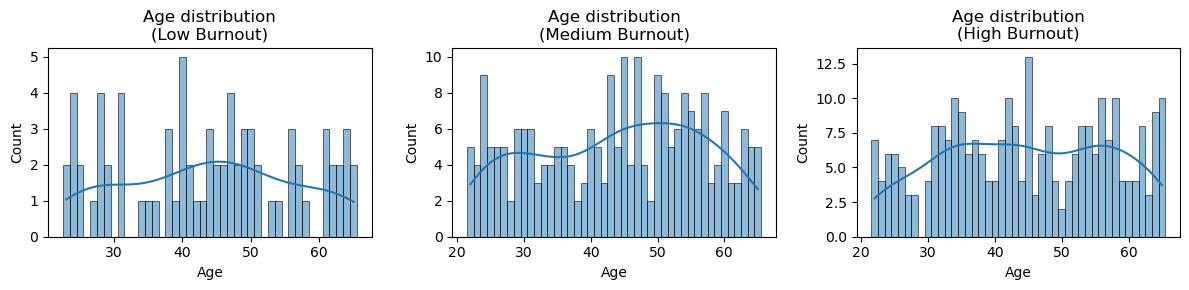

In [17]:
plot_boxplots('Age')

The `Age` distribution remote workers experiencing Low burnout is normal, while medium and high burnout show a more uniform distribution, indicating higher levels of burnout are experienced across various ages more consistently than Low burnout.

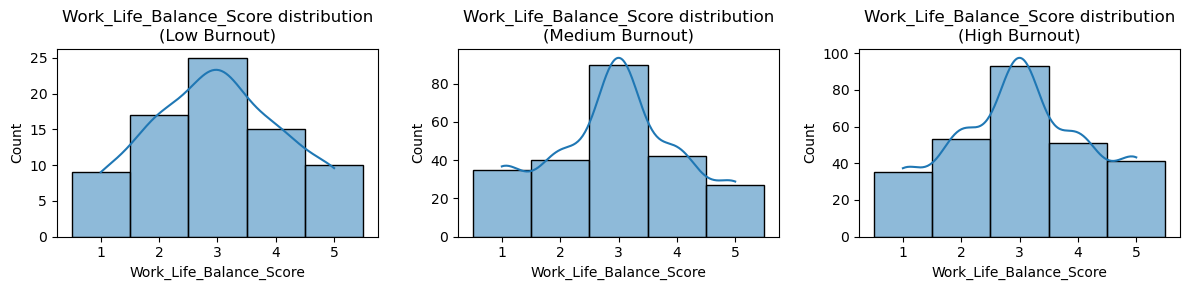

In [18]:
plot_boxplots('Work_Life_Balance_Score')

The `Work_Life_Balance_Score` distribution for medium and high burnout levels are more concentrated around the middle of the scale, indicating that individuals with medium and high burnout have less favorable work-life balance compared to those with low burnout.

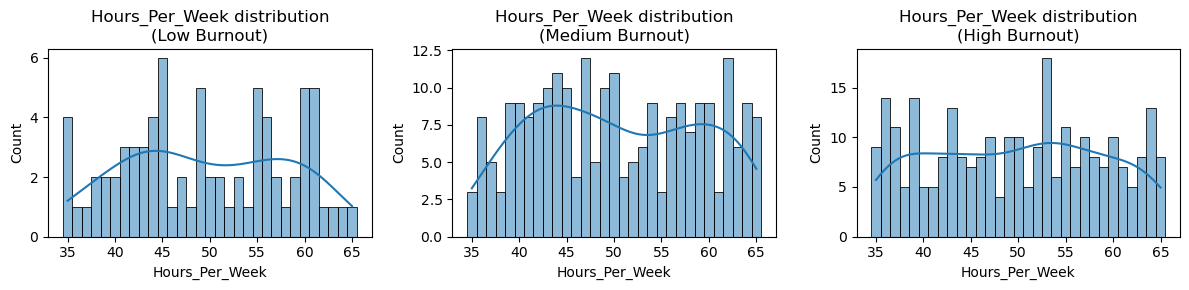

In [19]:
plot_boxplots('Hours_Per_Week')

The `Hours_Per_Week` distribution shifts from a left-skewed distribution to a more uniform distribution as burnout levels increase, indicating that individuals with higher burnout levels tend to work more hours per week.

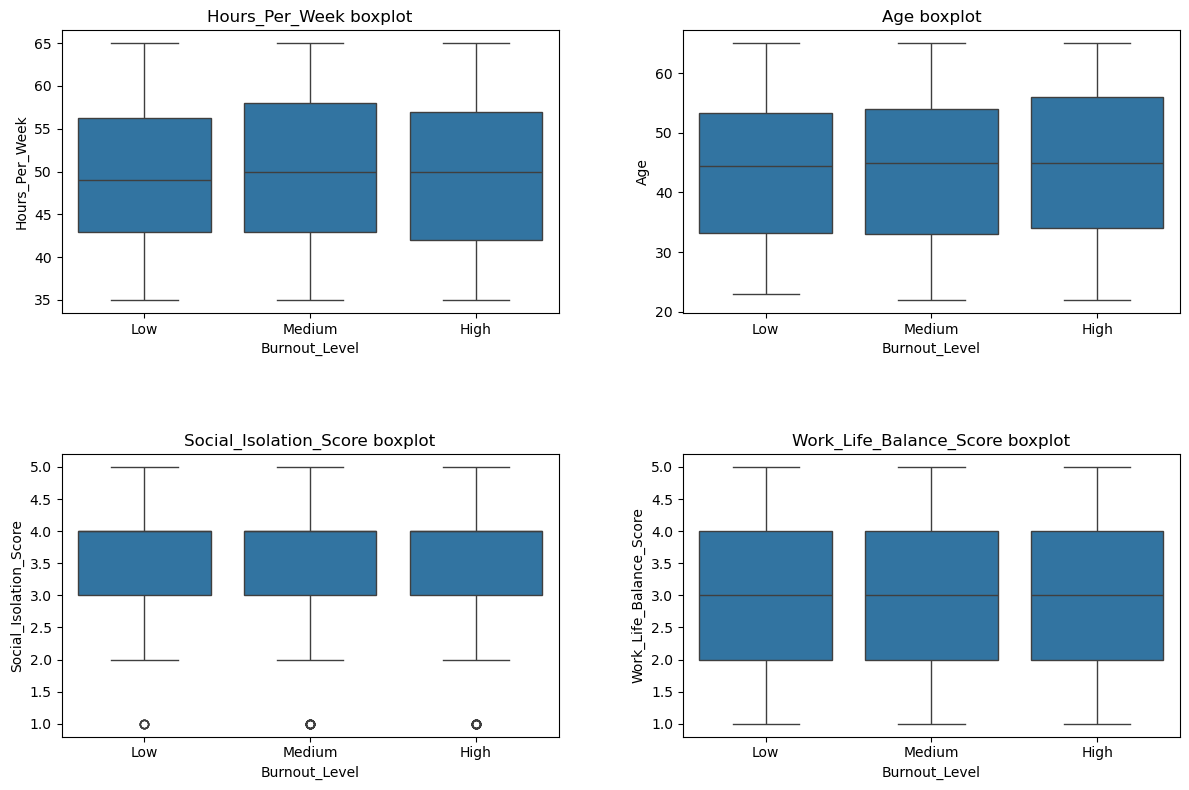

In [20]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        x=df_categorical["Burnout_Level"],
        y=df_numerical[col],
        order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} boxplot")
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.25)
plt.show()

The boxplot visualizations show that `Social_Isolation_Score` and `Work_Life_Balance_Score` have similar shapes across the different burnout categories.  

`Hours_Per_Week` shows a slight increase in the median and interquartile range as burnout levels increase. This suggests that individuals who work more hours are more likely to experience higher levels of burnout.  

`Age` shows the same median across all burnout levels, but the interquartile range widens as burnout levels increase, indicating more variability in age among those with higher burnout levels.

In [21]:
def plot_violin(col):
    sns.violinplot(
        x="Burnout_Level",
        y=col,
        data=pd.concat([df_categorical["Burnout_Level"], df_numerical], axis=1),
        inner="box",
        cut=0,
        order=["Low", "Medium", "High"],
        palette="Blues",
        hue="Burnout_Level",
        hue_order=["Low", "Medium", "High"],
    )
    plt.title(f"{col} by burnout level")
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.show()

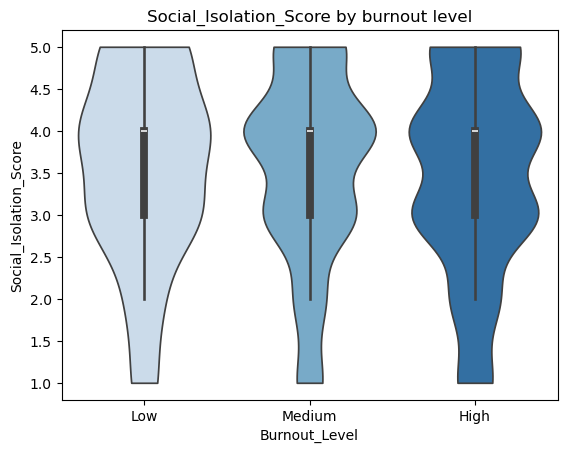

In [22]:
plot_violin('Social_Isolation_Score')

The distribution of `Social_Isolation_Score` is similar between all burnout levels, indicating that social isolation is a common factor across all levels of burnout.

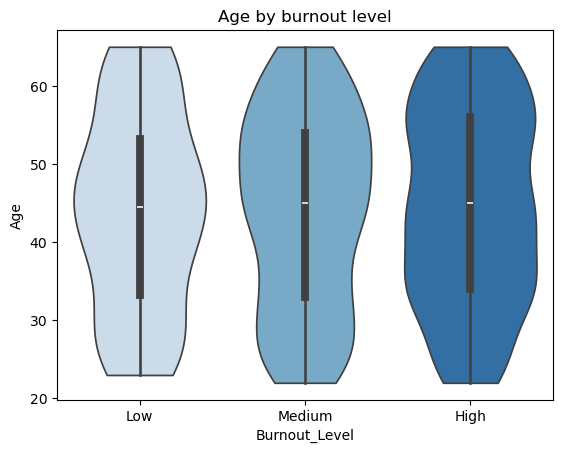

In [23]:
plot_violin('Age')

As `Burnout_Level` increases, the density of `Age` becomes more uniform, indicating that individuals with higher burnout levels are more evenly distributed across different age groups.

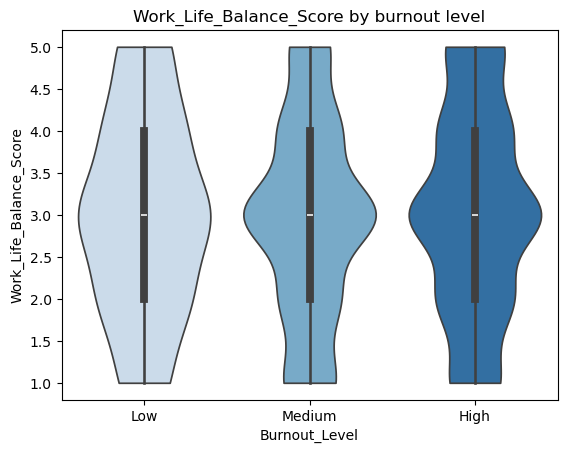

In [24]:
plot_violin('Work_Life_Balance_Score')

As `Burnout_Level` increases, the `Work_Life_Balance_Score` becomes more concentrated around the middle of the scale, indicating that individuals with higher burnout levels have less favorable work-life balance. Interestingly, there is a higher density of individuals with Low burnout who also have low `Work_Life_Balance_Score`, suggesting that some individuals with low burnout may still struggle with work-life balance.

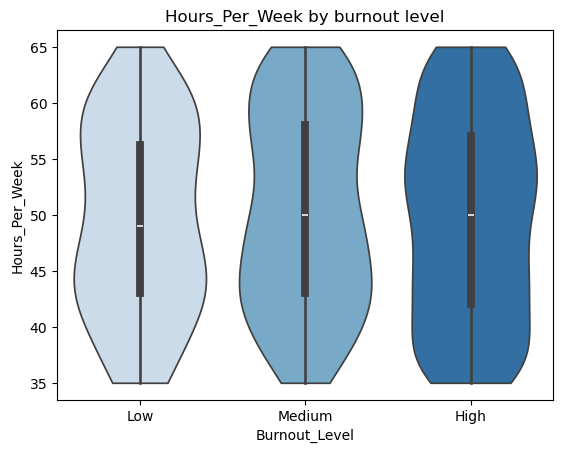

In [25]:
plot_violin('Hours_Per_Week')

As `Burnout_Level` increases, the density of `Hours_Per_Week` shifts from left skewed to uniformly distributed and the median increases, indicating that individuals with higher burnout levels tend to work more hours per week.

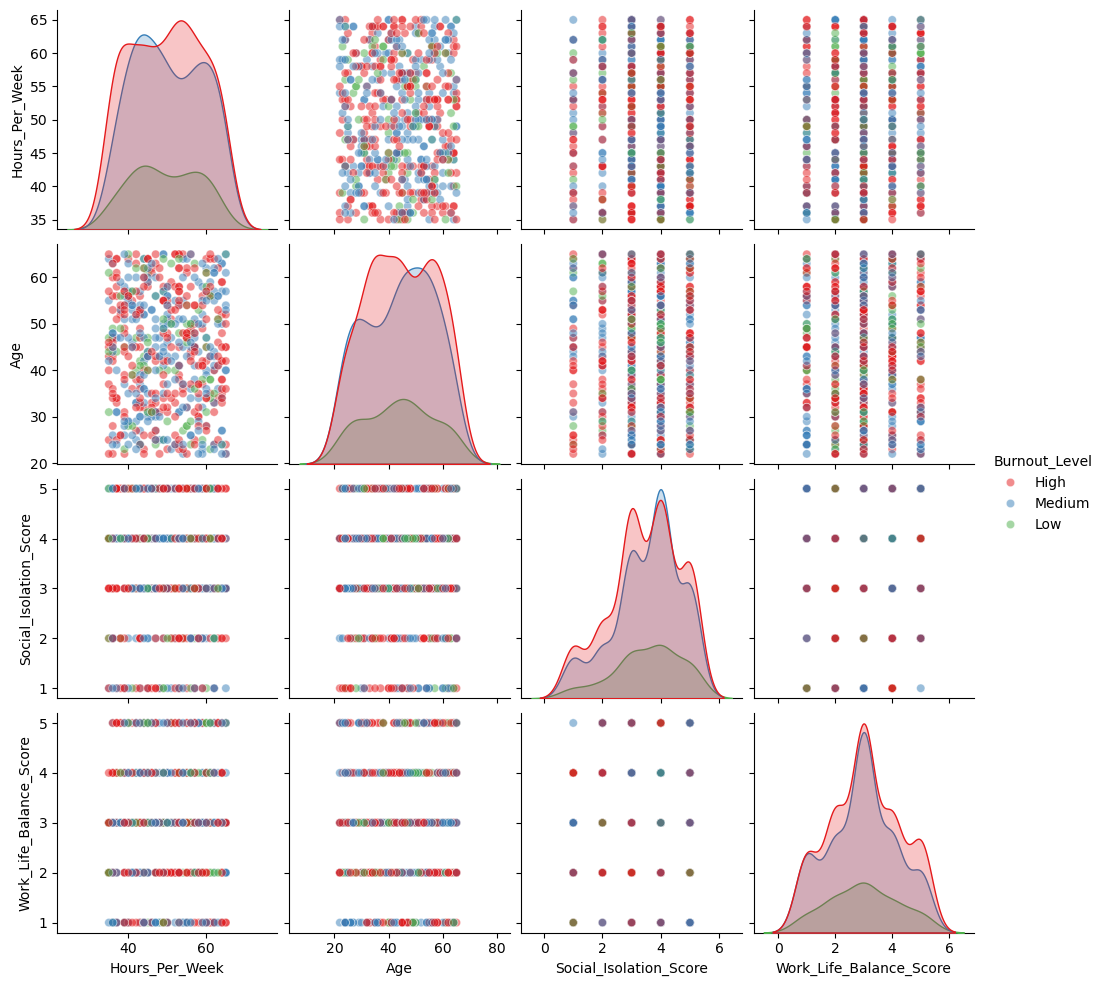

In [26]:
sns.pairplot(
    df_remote,
    vars=df_numerical.columns,
    diag_kind="kde",
    plot_kws={"alpha": 0.5},
    height=2.5,
    palette="Set1",
    hue="Burnout_Level",
    hue_order=["High", "Medium", "Low"],
)
plt.show()

- `Social_Isolation_Score` is positively correlated with burnout levels, with higher scores indicating larger densities in the medium and high burnout categories.
- `Work_Life_Balance_Score` shows a negative correlation with burnout levels, where lower scores are associated with larger densities in the medium and high burnout categories.

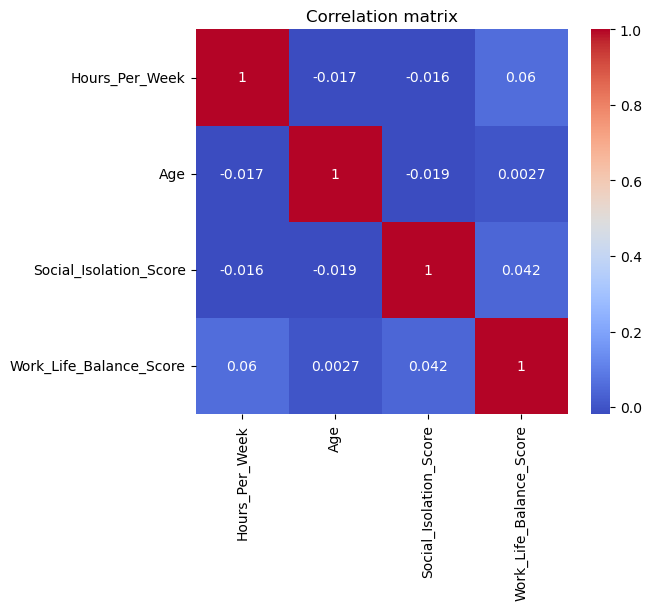

In [27]:
plt.figure(figsize=(6, 5))
corr = df_numerical.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

None of the numerical features show correlation with each other, indicating that they are all independent of each other.

## Significance Testing

In [28]:
print("T-test for Low vs Medium and High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] != "Low"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs Medium and High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,0.445484,0.656917,No significant difference
1,Age,0.241338,0.809796,No significant difference
2,Social_Isolation_Score,-0.439306,0.661391,No significant difference
3,Work_Life_Balance_Score,-0.053405,0.957516,No significant difference


The t-tests results indicate that there are no significant differences between the `High+Medium` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [29]:
print("T-test for Low vs High Burnout Levels")
ttest_ind_results = []
for col in numericals_cols:
    group1 = df_remote[df_remote["Burnout_Level"] == "Medium"][col]
    group0 = df_remote[df_remote["Burnout_Level"] == "Low"][col]
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    ttest_ind_results.append(
        {
            "Column": col,
            "T-statistic": t_stat,
            "P-value": p_val,
            "Conclusion": (
                "Significant difference"
                if p_val < 0.05
                else "No significant difference"
            ),
        }
    )
ttest_ind_results_df = pd.DataFrame(ttest_ind_results)
display(ttest_ind_results_df)

T-test for Low vs High Burnout Levels


,Column,T-statistic,P-value,Conclusion
0,Hours_Per_Week,0.674042,0.501472,No significant difference
1,Age,0.073407,0.941598,No significant difference
2,Social_Isolation_Score,-0.066108,0.947396,No significant difference
3,Work_Life_Balance_Score,-0.378509,0.705688,No significant difference


The t-tests results indicate that there are no significant differences between the `High` and `Low` burnout groups for the quantitative features. This suggests that the differences in the distributions of these features across burnout levels are not statistically significant.

In [30]:
chi2_results = []
for col in categorical_cols:
    if col == "Burnout_Level":
        continue
    contingency_table = pd.crosstab(df_remote[col], df_remote["Burnout_Level"])
    chi2_stat, p_val_chi2, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(
        {
            "Column": col,
            "Chi-squared Statistic": chi2_stat,
            "P-value": p_val_chi2,
            "Conclusion": (
                "Association exists" if p_val_chi2 < 0.05 else "No association"
            ),
        }
    )
chi2_results_df = pd.DataFrame(chi2_results)
display(chi2_results_df)

,Column,Chi-squared Statistic,P-value,Conclusion
0,Work_Arrangement,0.000000,1.000000,No association
1,Region,11.162435,0.345004,No association
2,Back_Pain,0.194708,0.907235,No association
3,Anxiety,9.354210,0.009306,Association exists
4,PTSD,0.879418,0.644224,No association
5,No_Mental_Health_Issues,0.156534,0.924717,No association
6,Depression,1.125678,0.569590,No association
7,Neck_Pain,0.632166,0.728999,No association
8,Gender,3.011242,0.807434,No association
9,Salary_Range,3.637548,0.888256,No association


The chi-squared test results indicate that only `Wrist_Pain` has an association with burnout levels, suggesting that individuals with wrist pain are more likely to experience higher levels of burnout.  

The other categorical features do not show significant associations with burnout levels, indicating that they may not be strong predictors of burnout.

## Models

In [31]:
# Target
mapping = {"Low": 0, "Medium": 1, "High": 2}
df_remote["Burnout_Level_Num"] = df_remote["Burnout_Level"].map(mapping)
y = df_remote["Burnout_Level_Num"]

# Features
feature_cols = [
    "Hours_Per_Week",
    "Work_Life_Balance_Score",
    "Wrist_Pain",
    "Anxiety",
]
X = df_remote[feature_cols]

display(X.head())
display(y.value_counts())

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

display(y_train_bal.value_counts())

,Hours_Per_Week,Work_Life_Balance_Score,Wrist_Pain,Anxiety
8,47,2,False,True
11,35,3,True,False
13,59,5,True,True
14,64,1,False,False
19,43,1,False,False


Burnout_Level_Num
2    273
1    234
0     76
Name: count, dtype: int64

Burnout_Level_Num
2    220
0    220
1    220
Name: count, dtype: int64

In [32]:
# Scale Numeric Features
numeric_cols = [
    "Hours_Per_Week",
    "Work_Life_Balance_Score",
]
scaler = StandardScaler()
X_train_bal_scaled = X_train_bal.copy()
X_test_scaled = X_test.copy()
X_train_bal_scaled[numeric_cols] = scaler.fit_transform(X_train_bal[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [33]:
# Train Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_bal_scaled, y_train_bal)

# Predict and Evaluate
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         Low       0.07      0.13      0.10        15
      Medium       0.47      0.33      0.39        49
        High       0.50      0.53      0.51        53

    accuracy                           0.39       117
   macro avg       0.35      0.33      0.33       117
weighted avg       0.43      0.39      0.41       117

[[ 2  2 11]
 [16 16 17]
 [ 9 16 28]]


#### Random Forest Results

- The model did a fair job identifying people at **High** burnout (about 63% recall, 50% precision).
- It was able to find some **Medium** burnout cases (33% recall).
- However, it poorly classified people in the **Low** burnout group (13% recall and 7% precision).
- This means the model mostly grouped everyone as Medium or High, and could not spot the people who are doing well.
- Overall, accuracy was about 39%, just a little better than random guessing for three groups.


In [34]:
clf_lr = LogisticRegression(
    multi_class="multinomial", max_iter=1000, random_state=42, class_weight="balanced"
)
clf_lr.fit(X_train_bal_scaled, y_train_bal)
y_pred_lr = clf_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr, target_names=["Low", "Medium", "High"]))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

         Low       0.11      0.47      0.18        15
      Medium       0.52      0.33      0.40        49
        High       0.71      0.32      0.44        53

    accuracy                           0.34       117
   macro avg       0.45      0.37      0.34       117
weighted avg       0.55      0.34      0.39       117

[[ 7  3  5]
 [31 16  2]
 [24 12 17]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


#### Logistic Regression Results

- This model did a better job than Random Forest at catching the **Low** burnout group (47% recall, 11% precision), even if still not great.
- It was also able to identify some **Medium** (33% recall) and **High** burnout cases (32% recall).
- Overall accuracy was lower (34%), but at least now the model isn’t missing all the “Low” cases.
- Still, the model often confused people between the groups, showing it’s a tough prediction problem.


In [35]:
# Fit model (set num_class=3 for your three burnout classes)
clf_xgb = XGBClassifier(objective="multi:softmax", num_class=3, random_state=42)
clf_xgb.fit(X_train_bal_scaled, y_train_bal)

# Predict
y_pred_xgb = clf_xgb.predict(X_test_scaled)

# Evaluate
print(classification_report(y_test, y_pred_xgb, target_names=["Low", "Medium", "High"]))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         Low       0.08      0.13      0.10        15
      Medium       0.44      0.35      0.39        49
        High       0.52      0.51      0.51        53

    accuracy                           0.39       117
   macro avg       0.34      0.33      0.33       117
weighted avg       0.43      0.39      0.41       117

[[ 2  5  8]
 [15 17 17]
 [ 9 17 27]]


#### Why We Switched to Binary Classification

We first attempted to classify burnout as Low, Medium, or High using Random Forest, Logistic Regression, and XGBoost. All three models struggled to identify the “Low” burnout group, with precision and recall close to zero for that class. After multiple attempts, we decided to merge the “Low” and “Medium” categories into a single “Not High” group and focus on predicting “High” burnout, which is the most actionable outcome for workplace interventions.


In [36]:
# Make a new binary target: 1 = High/Medium, 0 = Low
df_remote["Burnout_Binary"] = df_remote["Burnout_Level"].map(
    {"High": 1, "Medium": 1, "Low": 0}
)
y = df_remote["Burnout_Binary"]

# Repeating last models after binary  classification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale Numeric Features
numeric_cols = [
    "Hours_Per_Week",
    "Work_Life_Balance_Score",
]

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_bal_scaled = X_train_bal.copy()
X_test_scaled = X_test.copy()
X_train_bal_scaled[numeric_cols] = scaler.fit_transform(X_train_bal[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [37]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_bal_scaled, y_train_bal)

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=["Low", "High/Medium"]))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         Low       0.23      0.60      0.33        15
 High/Medium       0.92      0.70      0.79       102

    accuracy                           0.68       117
   macro avg       0.57      0.65      0.56       117
weighted avg       0.83      0.68      0.73       117

[[ 9  6]
 [31 71]]


#### Model Results

- The model has an overall recall of 68%, meaning is classifies the correct burnout level about 68% of the time across all classes.
- It predicts “High/Medium” burnout correctly 70% of the time (recall) and has a precision of 92% for this group.
- It predicts "Low" burnout correctly 60% of the time (recall) but has a lower precision of 23% for this group.

Overall: The model performs well in identifying individuals with "High/Medium" burnout, but it misclassified many "Low" burnout cases.

In [38]:
clf_lr = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
clf_lr.fit(X_train_bal_scaled, y_train_bal)
y_pred_lr = clf_lr.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr, target_names=["Low", "High/Medium"]))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

         Low       0.10      0.40      0.16        15
 High/Medium       0.85      0.49      0.62       102

    accuracy                           0.48       117
   macro avg       0.48      0.45      0.39       117
weighted avg       0.75      0.48      0.56       117

[[ 6  9]
 [52 50]]


In [39]:
clf_xgb = XGBClassifier(objective="binary:logistic", random_state=42)
clf_xgb.fit(X_train_bal_scaled, y_train_bal)
y_pred_xgb = clf_xgb.predict(X_test_scaled)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb, target_names=["Low", "High/Medium"]))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

         Low       0.21      0.53      0.30        15
 High/Medium       0.91      0.71      0.80       102

    accuracy                           0.68       117
   macro avg       0.56      0.62      0.55       117
weighted avg       0.82      0.68      0.73       117

[[ 8  7]
 [30 72]]


In [40]:
clf_svc = SVC(class_weight="balanced", probability=True, random_state=42)
clf_svc.fit(X_train_bal_scaled, y_train_bal)
y_pred_svc = clf_svc.predict(X_test_scaled)

print("SVM Results:")
print(classification_report(y_test, y_pred_svc, target_names=["Low", "High/Medium"]))
print(confusion_matrix(y_test, y_pred_svc))

SVM Results:
              precision    recall  f1-score   support

         Low       0.11      0.47      0.18        15
 High/Medium       0.86      0.47      0.61       102

    accuracy                           0.47       117
   macro avg       0.49      0.47      0.40       117
weighted avg       0.76      0.47      0.55       117

[[ 7  8]
 [54 48]]


#### Comparing Binary Models (High/Medium vs. Low Burnout)

- **Random Forest:**

  - Overall recall of 68%
  - Overall precision of 83%
  - High/Medium recall of 70% and precision of 92%
  - Low recall of 60% and precision of 23%
  - Most accurate model for classifying burnout levels. Performs better than random guessing.

- **Logistic Regression:**

  - Overall recall of 48%
  - Overall precision of 75%
  - High/Medium recall of 49% and precision of 85%
  - Low recall of 40% and precision of 10%
  - Does not perform better than random guessing for classifying burnout levels.

- **XGBoost:**

  - Overall recall of 68%
  - Overall precision of 82%
  - High/Medium recall of 71% and precision of 91%
  - Low recall of 52% and precision of 21%
  - Performs similarly to Random Forest, but with slightly lower scores.

- **SVM:**

  - Overall recall of 47%
  - Overall precision of 76%
  - High/Medium recall of 47% and precision of 86%
  - Low recall of 47% and precision of 11%
  - Does not perform better than random guessing for classifying burnout levels.

**Bottom line:**  
  - All models had trouble identifying Low burnout cases
  - All models tend to overestimate burnout levels by misclassifying Low burnout as Medium or High.
  - The available data may not have enough signal to make strong predictions.
  - Survey responses may not accurately reflect true burnout levels, leading to misclassifications.
  - The RandomForest binary model had the best performance overall and is the most reliable for identifying High/Medium burnout cases. High/Medium predictions should be considered seriously for workplace interventions, while Low predictions should be treated with caution due to potential misclassification. Even if Low burnout is misclassified as Medium or High, the precision of the High/Medium predictions is high enough to warrant action.
